In this notebook we use scatter plots to characterise the relationship between variables within a dataset.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import thinkplot
import thinkstats2

%matplotlib inline

# Read in bikeshare data

In [2]:
# read in data from a csv file
df = pd.read_csv('../Data/austin_bikeshare_trips.csv')

# Remove any trip with 0 minute duration
df = df[df['duration_minutes'] > 0]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

greater_than_2_hours = df[df['duration_minutes'] > 120]
frac_of_dataset = 100 * len(greater_than_2_hours) / len(df)

# Remove any trip lasting longer than 2 hours
df = df[df['duration_minutes'] <= 120]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

df['start_time'] = pd.to_datetime(df['start_time'])

df['date'] = df['start_time'].dt.date

# Read in weather data

In [3]:
# read in data from a csv file
weather_df = pd.read_csv('../Data/austin_weather.csv')

# Replace values with NaNs
weather_df.replace('-', np.nan, inplace=True)
weather_df.replace('T', np.nan, inplace=True)

# Convert column types to float
for col in weather_df:
    if col != 'Date' and col != 'Events':
        weather_df[[col]] = weather_df[[col]].astype(float)
        
# Convert the column type to the datetime type
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
# Set the index to that column
weather_df.index = weather_df['Date']
del weather_df['Date']

We've spent a fair amount of time examining the **duration_minutes** column within our dataset. Specifically, we've examined the CDF of this column by segmenting by day of the week. We saw that ridership is different between weekday and weekend rides.

However, we have reason to believe that the duration of a bike ride may also be affected by other variables. Specifically, the weather may have a large impact on the duration of a ride. Let's try to characterize this relationship.

First, let's characterize the relationship between temperature and duration. Let
s look at a timeseries plot of the temperature and plot CDFs for duration by month.

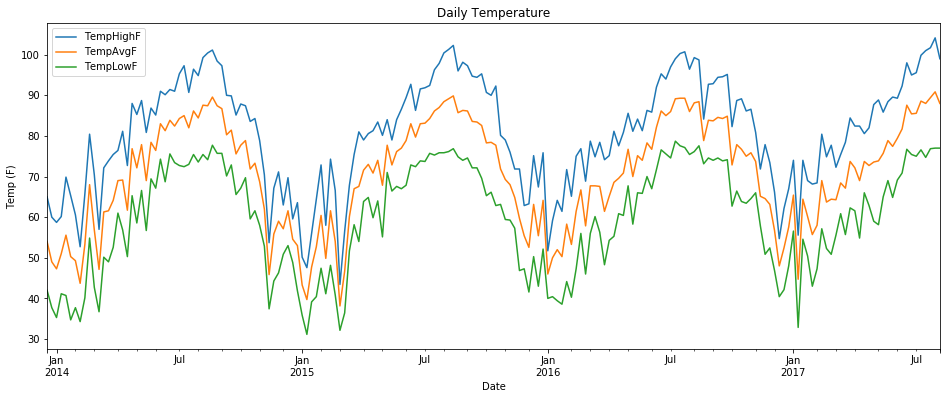

In [4]:
weather_df[['TempHighF', 'TempAvgF', 'TempLowF']].resample('W').mean().plot(
    title='Daily Temperature', figsize=(16, 6))

plt.ylabel('Temp (F)')
plt.show()

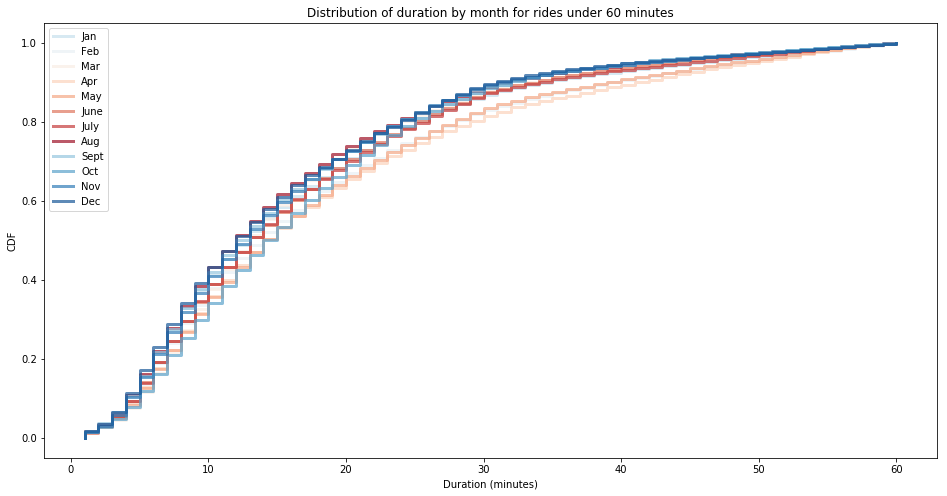

In [5]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
         'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

sub_60 = df[df['duration_minutes'] <= 60]

cdfs = [] 

for i in range(12):
    month_rides = sub_60[sub_60['month'] == i+1]
    cdf = thinkstats2.Cdf(month_rides['duration_minutes'], label=months[i])
    cdfs.append(cdf)
    
plt.figure(figsize=(16,8))
thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(title='Distribution of duration by month for rides under 60 minutes', 
                 xlabel='Duration (minutes)', ylabel='CDF')

If we segment the data by month of the year, we do see that the distribution of duration is different for different months. Notice that the CDFs for spring months are further to the right, signifying longer bike rides during those months. Rides are shorter during the coldest and warmest months of the year.

However, a scatterplot will serve us much better in visualizing the relationship between temperature and duration.

In [6]:
_df = df[['date', 'duration_minutes']].copy()
_df['date'] = pd.to_datetime(_df['date'])
_df_weather = weather_df[['Date', 'TempAvgF']]

_df = _df.merge(_df_weather, how='left', left_on='date', right_on='Date')

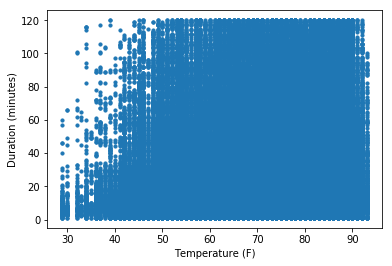

In [7]:
plt.scatter(_df['TempAvgF'], _df['duration_minutes'], s=10)

plt.ylabel('Duration (minutes)')
plt.xlabel('Temperature (F)')

plt.show()

Clearly, this isn't a very good plot. One of the problems is that there is too much data to plot. We can use the methods discussed in the text to improve the plot.

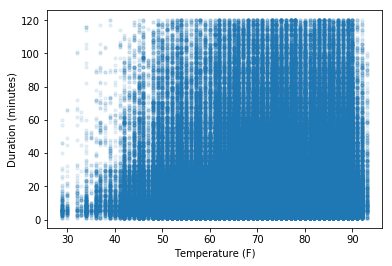

In [10]:
plt.scatter(_df['TempAvgF'], _df['duration_minutes'], s=10, alpha=.1)

plt.ylabel('Duration (minutes)')
plt.xlabel('Temperature (F)')

plt.show()

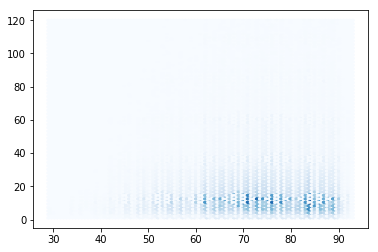

In [8]:
thinkplot.HexBin(_df['TempAvgF'], _df['duration_minutes'])

In our case, neither using transparency nor hex plots helped us out much. We can vary the parameters of the methods some more or look into the implementation of HexPlot to improve these, but we can use descriptive statistics to simplify this.

Rather than plot every single ride, we can resample our data by taking the mean bike ride duration of each day and scattering that against temperature.

In [11]:
# Computer the average duration of rides per day
_df = df[['start_time', 'duration_minutes']].copy()
_df.index = _df['start_time']
_df = _df.resample('D').mean()
_df = _df.join(weather_df)

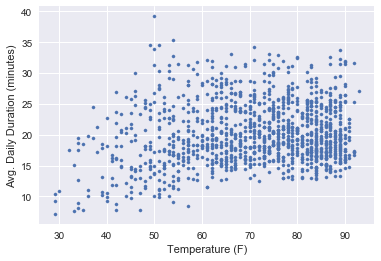

In [14]:
sns.set()

plt.scatter(_df['TempAvgF'], _df['duration_minutes'], s=10)

plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Temperature (F)')

plt.show()

Much better. Of course, we've reduced the amount of information we can analyze by resampling, but we've also eliminated much of the noise and created a visualization that pulls out meaningful information - a correlation between temperature and the average daily duration.

Notice that the avg. duration is lower on colder days. In fact, there is what seems a strong correlation between temperature and avg. daily duration on days where the average temperature is less than 60 degrees.

In [26]:
sns.set_style('white')

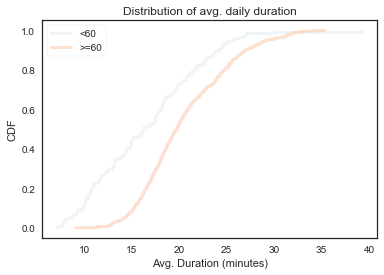

In [29]:
sub_60_df = _df[_df['TempHighF'] < 60]
greater_60_df = _df[_df['TempHighF'] >= 60]

cdfs = [thinkstats2.Cdf(sub_60_df['duration_minutes'], label='<60'),
       thinkstats2.Cdf(greater_60_df['duration_minutes'], label='>=60')] 
    
thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(title='Distribution of avg. daily duration', 
                 xlabel='Avg. Duration (minutes)', ylabel='CDF')

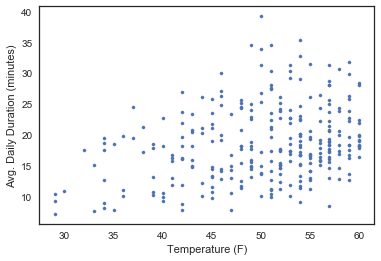

In [30]:
plt.scatter(sub_60_degrees['TempAvgF'], sub_60_degrees['duration_minutes'], s=10)

plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Temperature (F)')

plt.show()

In [23]:
sub_60_degrees[['duration_minutes', 'TempAvgF']].corr()

,duration_minutes,TempAvgF
duration_minutes,1.000000,0.299576
TempAvgF,0.299576,1.000000


In [24]:
sub_60_degrees[['duration_minutes', 'TempAvgF']].corr(method='spearman')

,duration_minutes,TempAvgF
duration_minutes,1.00000,0.26688
TempAvgF,0.26688,1.00000


The correlation between average daily ride duration and the temperature for days where the avg. daily temperature is under $60$ degrees (F) is not very high - about $0.3$. Not a very strong linear relationship.